# **Random Forest**: *Forecasting 30 days time step Closing Price given past 30 days data*

In [177]:
import csv
import random
import math
import operator
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

1. **Importing of data**

In [178]:
stock = 'aapl'
country = 'us'

df = pd.read_csv(f'{stock}.{country}.txt', index_col=0)
df.drop('OpenInt', inplace=True, axis=1) # remove OpenInt column seems 
df.tail()


,Open,High,Low,Close,Volume
Date,,,,,
2017-11-06,171.75,174.36,171.10,173.63,34901241
2017-11-07,173.29,174.51,173.29,174.18,24424877
2017-11-08,174.03,175.61,173.71,175.61,24451166
2017-11-09,174.48,175.46,172.52,175.25,29533086
2017-11-10,175.11,175.38,174.27,174.67,25130494


2. **Visulizing Data Set**

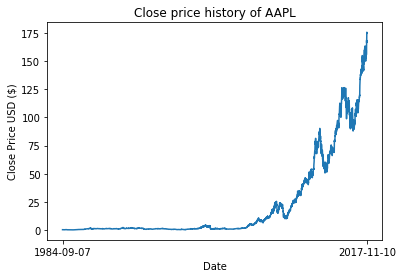

In [179]:
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

3. **Feature Engineering**

In [180]:
def feature_engineering(data):
  df = DataFrame(data)

  #percentage change with respect to open
  df_new = df.loc[:,['Open','Close','Volume']]
  df_new['Relative High'] = (df['High']/ df['Open']) 
  df_new['Relative Low'] = (df['Low']/ df['Open'])
  df_new['Relative Close'] = (df['Close']/ df['Open'])

  return df_new

print("New Data Set: ")
print(new_df.shape)
new_df = feature_engineering(df)
new_df.tail()


New Data Set: 
(8364, 6)


,Open,Close,Volume,Relative High,Relative Low,Relative Close
Date,,,,,,
2017-11-06,171.75,173.63,34901241,1.015197,0.996215,1.010946
2017-11-07,173.29,174.18,24424877,1.007040,1.000000,1.005136
2017-11-08,174.03,175.61,24451166,1.009079,0.998161,1.009079
2017-11-09,174.48,175.25,29533086,1.005617,0.988767,1.004413
2017-11-10,175.11,174.67,25130494,1.001542,0.995203,0.997487


4. **Spiting Data into Training and Test Set**

In [181]:
def split_data(data, ratio):
    num_of_data = data.shape[0]
    num_of_training = round(num_of_data * ratio)
    num_of_testing = num_of_data - num_of_training  


    return data[:-num_of_testing], data[-num_of_testing:]

train_set, test_set = split_data(new_df, 0.8)

print("Train Set:")
print(train_set.shape)

print("Test Set")
print(test_set.shape)



Train Set:
(6691, 6)
Test Set
(1673, 6)


5. **Converting Time Series Data for Supervised Learning**

In [182]:
def convert_data(data, time_step_history, time_step_forecast):
    df_con = DataFrame()

    cols = []
    headers = ['Relative High', 'Relative Low', 'Relative Close', 'Volume']

    for i in range(0,time_step_history+1):
      for j in range(0, len(headers)):
          c = headers[j]
          # print(headers)
          header = f'{c}(t-{i})'
          df_con[header] = data[c].shift(i)
          cols.append(header)

    df_con['Close'] = data['Close']
    label = f'C(t+{time_step_forecast})'
    df_con[label] = data['Close'].shift(-time_step_forecast)/data['Close']

    cols.append(label)
    df_con.dropna(inplace=True)
    return df_con

time_step_history = 30
time_step_forecast = 30
df_converted_train = convert_data(train_set, time_step_history, time_step_forecast)
df_converted_test = convert_data(test_set, time_step_history, time_step_forecast)
print(f"converted train set shape: {df_converted_train.shape}")
print(f"converted test set shape: {df_converted_test.shape}")
print("converted train set: ")
df_converted_train.head()


converted train set shape: (6631, 126)
converted test set shape: (1613, 126)
converted train set: 


,Relative High(t-0),Relative Low(t-0),Relative Close(t-0),Volume(t-0),Relative High(t-1),Relative Low(t-1),Relative Close(t-1),Volume(t-1),Relative High(t-2),Relative Low(t-2),Relative Close(t-2),Volume(t-2),Relative High(t-3),Relative Low(t-3),Relative Close(t-3),Volume(t-3),Relative High(t-4),Relative Low(t-4),Relative Close(t-4),Volume(t-4),Relative High(t-5),Relative Low(t-5),Relative Close(t-5),Volume(t-5),Relative High(t-6),Relative Low(t-6),Relative Close(t-6),Volume(t-6),Relative High(t-7),Relative Low(t-7),Relative Close(t-7),Volume(t-7),Relative High(t-8),Relative Low(t-8),Relative Close(t-8),Volume(t-8),Relative High(t-9),Relative Low(t-9),Relative Close(t-9),Volume(t-9),...,Relative Close(t-21),Volume(t-21),Relative High(t-22),Relative Low(t-22),Relative Close(t-22),Volume(t-22),Relative High(t-23),Relative Low(t-23),Relative Close(t-23),Volume(t-23),Relative High(t-24),Relative Low(t-24),Relative Close(t-24),Volume(t-24),Relative High(t-25),Relative Low(t-25),Relative Close(t-25),Volume(t-25),Relative High(t-26),Relative Low(t-26),Relative Close(t-26),Volume(t-26),Relative High(t-27),Relative Low(t-27),Relative Close(t-27),Volume(t-27),Relative High(t-28),Relative Low(t-28),Relative Close(t-28),Volume(t-28),Relative High(t-29),Relative Low(t-29),Relative Close(t-29),Volume(t-29),Relative High(t-30),Relative Low(t-30),Relative Close(t-30),Volume(t-30),Close,C(t+30)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984-10-19,1.068906,0.996842,1.000000,90949795,1.006315,1.000000,1.000000,68929180.0,1.006474,1.000000,1.000000,43685142.0,1.003395,0.996735,0.996735,32915346.0,1.010055,1.000000,1.000000,67842205.0,1.006806,0.949322,0.956076,74126674.0,1.026779,0.993240,0.993240,50969114.0,1.000000,0.970699,0.970699,101750813.0,1.006474,0.990352,0.990352,34933112.0,1.006474,1.000000,1.000000,13099922.0,...,1.000000,18453585.0,1.011668,0.979683,0.979683,29641922.0,1.008421,0.963559,0.963559,27136886.0,1.013977,1.000000,1.000000,53755262.0,1.034891,1.000000,1.011668,68847968.0,1.002846,1.000000,1.000000,57822062.0,1.005944,0.970071,0.970071,37125801.0,1.027096,1.000000,1.009079,42498199.0,1.003020,0.975889,0.994008,18022532.0,1.012126,0.987874,1.000000,23220030.0,0.40853,0.952978
1984-10-22,1.015617,0.993636,0.993636,32003288,1.068906,0.996842,1.000000,90949795.0,1.006315,1.000000,1.000000,68929180.0,1.006474,1.000000,1.000000,43685142.0,1.003395,0.996735,0.996735,32915346.0,1.010055,1.000000,1.000000,67842205.0,1.006806,0.949322,0.956076,74126674.0,1.026779,0.993240,0.993240,50969114.0,1.000000,0.970699,0.970699,101750813.0,1.006474,0.990352,0.990352,34933112.0,...,0.991129,27842780.0,1.008825,1.000000,1.000000,18453585.0,1.011668,0.979683,0.979683,29641922.0,1.008421,0.963559,0.963559,27136886.0,1.013977,1.000000,1.000000,53755262.0,1.034891,1.000000,1.011668,68847968.0,1.002846,1.000000,1.000000,57822062.0,1.005944,0.970071,0.970071,37125801.0,1.027096,1.000000,1.009079,42498199.0,1.003020,0.975889,0.994008,18022532.0,0.40593,0.977976
1984-10-23,1.009231,1.000000,1.000000,51993625,1.015617,0.993636,0.993636,32003288.0,1.068906,0.996842,1.000000,90949795.0,1.006315,1.000000,1.000000,68929180.0,1.006474,1.000000,1.000000,43685142.0,1.003395,0.996735,0.996735,32915346.0,1.010055,1.000000,1.000000,67842205.0,1.006806,0.949322,0.956076,74126674.0,1.026779,0.993240,0.993240,50969114.0,1.000000,0.970699,0.970699,101750813.0,...,0.991003,22033109.0,1.029571,0.979254,0.991129,27842780.0,1.008825,1.000000,1.000000,18453585.0,1.011668,0.979683,0.979683,29641922.0,1.008421,0.963559,0.963559,27136886.0,1.013977,1.000000,1.000000,53755262.0,1.034891,1.000000,1.011668,68847968.0,1.002846,1.000000,1.000000,57822062.0,1.005944,0.970071,0.970071,37125801.0,1.027096,1.000000,1.009079,42498199.0,0.41491,1.003061
1984-10-24,1.012275,1.000000,1.000000,46577491,1.009231,1.000000,1.000000,51993625.0,1.015617,0.993636,0.993636,32003288.0,1.068906,0.996842,1.000000,90949795.0,1.006315,1.000000,1.000000,6892918

5. **Training Random Forest Model**

In [190]:
def split_input_label(data, time_step_forecast):

    label = DataFrame()
    label['Close'] = data['Close']
    temp = f'C(t+{time_step_forecast})'
    label[temp] = data[temp]
    input = data.drop(['Close', temp], axis = 1)

    return input, label


def train_random_forest(input, label):
  train_x = asarray(input)
  train_y = asarray(label[f'C(t+{time_step_forecast})'])
  model = RandomForestRegressor(n_estimators=1000)
  rfm = model.fit(train_x,train_y)
  return rfm



input, label = split_input_label(df_converted_train, time_step_forecast)
print(f"input shape: {input.shape}")
print(f"label shape: {label.shape}")
print("input: ")
input.tail()

model = train_random_forest(input, label)

input shape: (6631, 124)
label shape: (6631, 2)
input: 


6. **Evaluation**

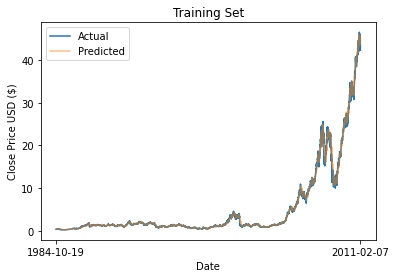

Train mse = 0.8677273214090839


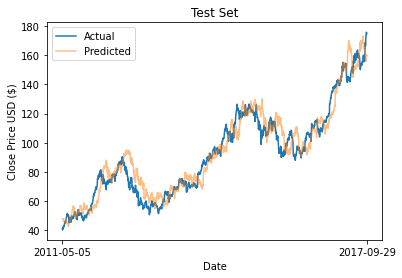

Test mse = -0.22112527304175056


In [219]:
test_input , test_label = split_input_label(df_converted_test, time_step_forecast)  
train_predict = model.predict(asarray(input))
test_predict = model.predict(asarray(test_input))

mse_train = model.score(asarray(input), asarray(label['C(t+30)']))
mse_test = model.score(asarray(test_input), asarray(test_label['C(t+30)']))

#plot training
label['Prediction'] = train_predict 
label['Actual Close'] = label['Close'] * label['C(t+30)']
label['Predicted Close'] = label['Close'] * label['Prediction']
plt.title('Training Set')
plt.plot(label['Actual Close'], label='Actual')
plt.plot(label['Predicted Close'], label='Predicted', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(label.index.values)[0], list(label.index.values)[-1]])
plt.legend()
plt.show()

print(f"Train mse = {mse_train}")


#plot validation
test_label['Prediction'] = test_predict 
test_label['Actual Close'] = test_label['Close'] * test_label['C(t+30)']
test_label['Predicted Close'] = test_label['Close'] * test_label['Prediction']
plt.title('Test Set')
plt.plot(test_label['Actual Close'], label='Actual')
plt.plot(test_label['Predicted Close'], label='Predicted', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(test_label.index.values)[0], list(test_label.index.values)[-1]])
plt.legend()
plt.show()

print(f"Test mse = {mse_test}")